In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import torch
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import diags
from scipy.sparse import eye
from pathlib import Path
from functools import partial
import networkx as nx
from sklearn.decomposition import PCA



In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

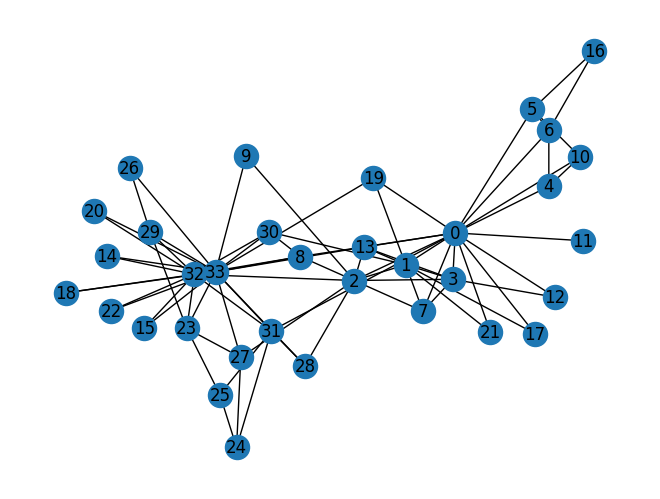

In [3]:
G = nx.karate_club_graph()
nx.draw(G, with_labels = True)

In [4]:
num_nodes = G.number_of_nodes()
embs = nn.Embedding(num_embeddings=num_nodes, embedding_dim=128)
num_nodes
# Find the connected components
connected_components = list(nx.connected_components(G))
print(connected_components)

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]


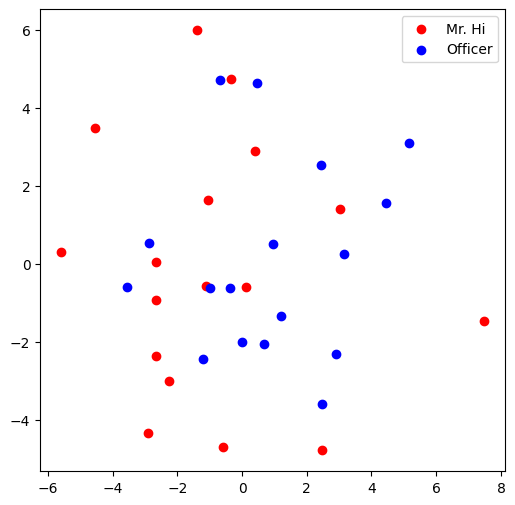

In [5]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="Officer")
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
visualize_emb(embs)

In [6]:
edges = np.asarray(list(G.edges()))
#edges

In [7]:
adj = coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                 shape=(num_nodes, num_nodes), dtype=np.float32)

adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

In [8]:
def normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = (rowsum ** -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [9]:
nn.init.normal_(embs.weight, std=0.1)

Parameter containing:
tensor([[-0.1715,  0.0054,  0.1416,  ..., -0.1166,  0.0626,  0.0443],
        [ 0.1446,  0.0331,  0.1268,  ..., -0.0449,  0.0120,  0.0417],
        [-0.1270,  0.0487, -0.0099,  ..., -0.0012,  0.0108, -0.0947],
        ...,
        [-0.0405, -0.1887,  0.0032,  ..., -0.0061, -0.1162,  0.0391],
        [-0.0378, -0.0251, -0.0598,  ..., -0.1208, -0.0589,  0.1267],
        [ 0.1589,  0.1329, -0.0667,  ...,  0.0581, -0.1427,  0.0127]],
       requires_grad=True)

In [10]:
adj = normalize(adj + eye(adj.shape[0])) #Normalizing for removing gradient vanishing and exploding problem

In [11]:
np.random.seed(34)
# num_links is not a correct term!
num_links = 561
n_train = 460
n_val = 101
n_test = num_links - n_train - n_val
idxs = np.random.permutation(num_links)
idx_train = torch.LongTensor(idxs[:n_train])
idx_val   = torch.LongTensor(idxs[n_train:n_train+n_val])
idx_test  = torch.LongTensor(idxs[n_train+n_val:])

In [12]:
# Prepare positive and negative edges for link prediction, create corresponding labels, and combine them for training

pos_edge_list = edges
pos_edge_index = torch.tensor(pos_edge_list, dtype=torch.long).t().contiguous()
# Convert pos_edge_list to a set of tuples for efficient lookup
pos_edge_set = set((i, j) for i, j in pos_edge_list)

neg_edge_list = []
for i in range(num_nodes - 1):
    for j in range(i + 1, num_nodes):
      if(not (i, j) in pos_edge_set):
        neg_edge_list.append((i,j))

neg_edge_index = torch.tensor(neg_edge_list, dtype=torch.long).t().contiguous()
print(pos_edge_index.shape)
print(neg_edge_index.shape)

pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )
train_label = torch.cat([pos_label, neg_label], dim=0)

train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)


torch.Size([2, 78])
torch.Size([2, 483])


In [13]:
adj = torch.FloatTensor(adj.todense())
labels = train_label.long()

In [14]:
adj = adj.to(device)
embs = embs.to(device)
labels = labels.to(device)
idx_train = idx_train.to(device)
idx_val = idx_val.to(device)
idx_test = idx_test.to(device)

In [15]:
class LightGCN(nn.Module):
    def __init__(self, num_layers, train_edge, embs):
        super(LightGCN, self).__init__()

        self.embedding = embs
        self.train_edge = train_edge
        self.num_layers = num_layers
        self.sigmoid = nn.Sigmoid()


    def forward(self, adj):
        x = self.embedding.weight
        for _ in range(self.num_layers):
            x = torch.spmm(adj, x)  # Sparse matrix multiplication

        emb_nodes = x[train_edge]
        vector1 = emb_nodes[0]
        vector2 = emb_nodes[1]
        vector2_transposed = vector2.transpose(0, 1)
        dot_product_matrix = torch.matmul(vector1, vector2_transposed)
        dot_product = torch.diagonal(dot_product_matrix).squeeze()
        pred = self.sigmoid(dot_product)
        pred = pred.squeeze()

        return pred

In [16]:
n_labels = labels.max().item() + 1
n_nodes = len(labels)
n_labels

2

In [17]:
torch.manual_seed(34)

model = LightGCN(num_layers=2,
                 train_edge=train_edge,
                 embs=embs)
optimizer = optim.Adam(model.parameters(),
                       lr=0.001, weight_decay=5e-4)


model = model.to(device)
loss_fn = nn.BCELoss()

def step():
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(adj)
    float_labels = labels.float()
    loss = loss_fn(output[idx_train], float_labels[idx_train])
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()

    return loss.item(), acc

def evaluate(idx):
    model.eval()
    output = model(adj)
    float_labels = labels.float()
    loss = loss_fn(output[idx], float_labels[idx])
    acc = accuracy(output[idx], float_labels[idx])

    return loss.item(), acc

In [18]:
def accuracy(output, labels):
    rounded_preds = torch.round(output)
    correct = (rounded_preds == labels).float()
    accu = correct.sum() / len(correct)
    return round(accu.item(), 4)

In [19]:
epochs = 1000
print_steps = 100
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for i in tqdm(range(epochs)):
    tl, ta = step()
    train_loss += [tl]
    train_acc += [ta]

    if((i+1)%print_steps) == 0 or i == 0:
        tl, ta = evaluate(idx_train)
        vl, va = evaluate(idx_val)
        val_loss += [vl]
        val_acc += [va]

        print('Epochs: {}, Train Loss: {:.3f}, Train Acc: {:.3f}, Validation Loss: {:.3f}, Validation Acc: {:.3f}'.format(i, tl, ta, vl, va))

  1%|▏         | 13/1000 [00:04<03:51,  4.27it/s] 

Epochs: 0, Train Loss: 0.708, Train Acc: 0.150, Validation Loss: 0.710, Validation Acc: 0.139


 12%|█▎        | 125/1000 [00:04<00:09, 87.78it/s]

Epochs: 99, Train Loss: 0.654, Train Acc: 0.622, Validation Loss: 0.664, Validation Acc: 0.634


 22%|██▏       | 224/1000 [00:05<00:04, 166.72it/s]

Epochs: 199, Train Loss: 0.631, Train Acc: 0.654, Validation Loss: 0.652, Validation Acc: 0.644


 34%|███▍      | 341/1000 [00:05<00:03, 210.01it/s]

Epochs: 299, Train Loss: 0.616, Train Acc: 0.674, Validation Loss: 0.644, Validation Acc: 0.663


 46%|████▌     | 456/1000 [00:06<00:01, 316.35it/s]

Epochs: 399, Train Loss: 0.610, Train Acc: 0.704, Validation Loss: 0.640, Validation Acc: 0.683


 56%|█████▌    | 558/1000 [00:06<00:01, 311.81it/s]

Epochs: 499, Train Loss: 0.607, Train Acc: 0.709, Validation Loss: 0.639, Validation Acc: 0.693


 67%|██████▋   | 669/1000 [00:06<00:00, 348.06it/s]

Epochs: 599, Train Loss: 0.606, Train Acc: 0.711, Validation Loss: 0.638, Validation Acc: 0.693


 74%|███████▍  | 740/1000 [00:07<00:00, 340.57it/s]

Epochs: 699, Train Loss: 0.606, Train Acc: 0.711, Validation Loss: 0.638, Validation Acc: 0.703


 84%|████████▍ | 842/1000 [00:07<00:00, 283.60it/s]

Epochs: 799, Train Loss: 0.605, Train Acc: 0.711, Validation Loss: 0.638, Validation Acc: 0.703


 93%|█████████▎| 926/1000 [00:07<00:00, 260.46it/s]

Epochs: 899, Train Loss: 0.605, Train Acc: 0.711, Validation Loss: 0.638, Validation Acc: 0.703


100%|██████████| 1000/1000 [00:08<00:00, 123.02it/s]

Epochs: 999, Train Loss: 0.605, Train Acc: 0.711, Validation Loss: 0.638, Validation Acc: 0.703


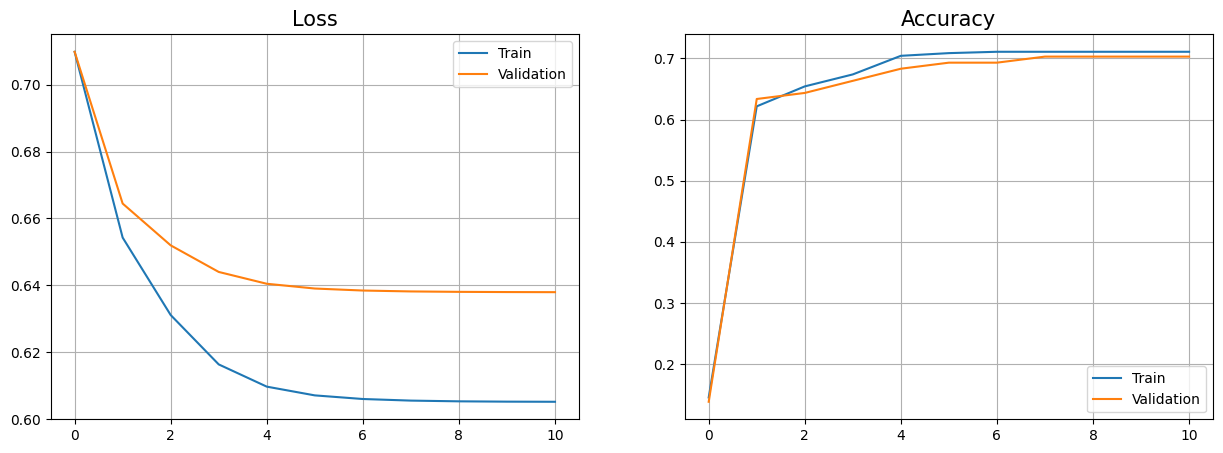

In [20]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

ax = axes[0]
axes[0].plot(train_loss[::print_steps] + [train_loss[-1]], label='Train')
axes[0].plot(val_loss, label='Validation')
train_acc_cpu = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in train_acc]
val_acc_cpu = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in val_acc]
axes[1].plot(train_acc_cpu[::print_steps] + [train_acc_cpu[-1]], label='Train')
axes[1].plot(val_acc_cpu, label='Validation')
axes[0].grid()
axes[1].grid()

for ax, t in zip(axes, ['Loss','Accuracy']):
    ax.legend(), ax.set_title(t, size=15)

In [21]:
output = model(adj)

In [22]:
samples = 10
idx_sample = idx_test[torch.randperm(len(idx_test))[:samples]]

idx2lbl = {v:k for k,v in lbl2idx.items()}
df = pd.DataFrame({'Real': [idx2lbl[e] for e in labels[idx_sample].tolist()],
                   'Pred': [idx2lbl[e] for e in output[idx_sample].argmax(1).tolist()]})
df

NameError: name 'lbl2idx' is not defined